In [1]:
import openeo
import logging
import os
from pathlib import Path
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
backend = "https://openeo.vito.be/openeo/0.4.2"

conn = openeo.connect(backend)

In [4]:
conn.list_collection_ids()

['BIOPAR_FAPAR_V1_GLOBAL',
 'CGLS_FAPAR_V2_GLOBAL',
 'CGLS_LAI_V2_GLOBAL',
 'CGLS_LAI300_V1_GLOBAL',
 'CGLS_NDVI300_V1_GLOBAL',
 'CGLS_BA300_V1_GLOBAL',
 'S1_GRD_SIGMA0_ASCENDING',
 'S1_GRD_SIGMA0_DESCENDING',
 'CGS_SENTINEL2_RADIOMETRY_V102_001',
 'S2_FAPAR_V102_WEBMERCATOR2',
 'SENTINEL2_FCOVER_TERRASCOPE',
 'SENTINEL2_NDVI_TERRASCOPE',
 'SENTINEL2_LAI_TERRASCOPE',
 'PROBAV_L3_S10_TOC_NDVI_333M',
 'S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID',
 'S2_NDVI_S3',
 'CGS_SENTINEL2_RADIOMETRY_V102_FILE',
 'SENTINEL1_GAMMA0_SENTINELHUB',
 'SENTINEL2_L1C_SENTINELHUB',
 'SENTINEL2_L2A_SENTINELHUB',
 'LANDSAT8_L1C_SENTINELHUB',
 'S2_RADIOMETRY_S3_JP2']

In [5]:
udf = """

from eolearn.core import MapFeatureTask, FeatureType
from eolearn.core import EOPatch, FeatureType
from sentinelhub import BBox, CRS
import numpy as np
from openeo_udf.api.base import UdfData, RasterCollectionTile, SpatialExtent

def udf_to_eopatch(udf_data):
    eopatch = EOPatch()

    for tile in udf_data.raster_collection_tiles:
        eopatch[(FeatureType.DATA, tile.id)] = tile.data[..., np.newaxis]

    extent = udf_data.raster_collection_tiles[0].extent
    bbox = BBox((extent.left, extent.bottom, extent.right, extent.top), CRS.WGS84)
    eopatch.bbox = bbox

    return eopatch

patch = udf_to_eopatch(data)

in_names = [name for name in patch.data]
out_names = ['moved_' + name for name in patch.data]

# create a trivial EOTask to multiply numpy arrays by -200
multiply = MapFeatureTask({FeatureType.DATA: in_names},
                          {FeatureType.DATA: out_names},
                          lambda f: f*-200)

patch = multiply(patch)

# assign resulting arrays back to the tile
for tile, out_name in zip(data.raster_collection_tiles, out_names):
    tile.set_data(patch[(FeatureType.DATA, out_name)].squeeze())
"""

In [34]:
product = "CGS_SENTINEL2_RADIOMETRY_V102_001"

cube = (
    conn
    .load_collection(product)
    .filter_temporal("2019-10-01", "2019-10-20")
    .filter_bbox(west=5.1, south=51.1, east=5.11, north=51.11, crs="EPSG:4326")
    .apply_dimension(udf, runtime="Python")
)

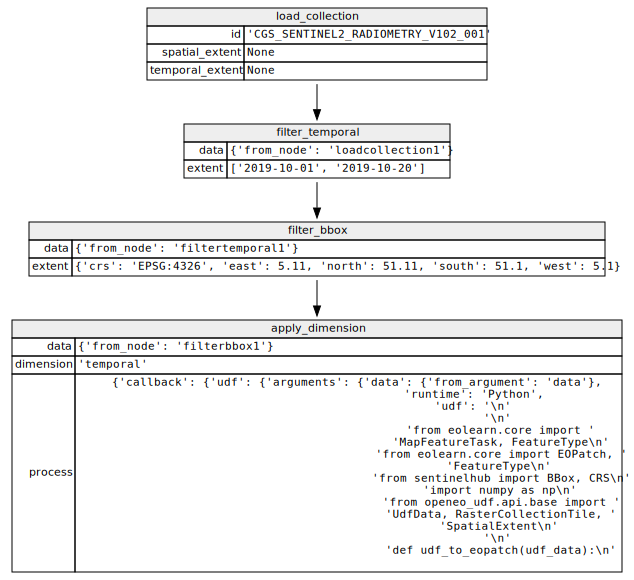

In [35]:
cube.to_graphviz()

In [36]:
%%time
cube.download("hackathon-udf-example-test01.tiff", format="GTIFF")

CPU times: user 11 ms, sys: 6.15 ms, total: 17.2 ms
Wall time: 11.3 s


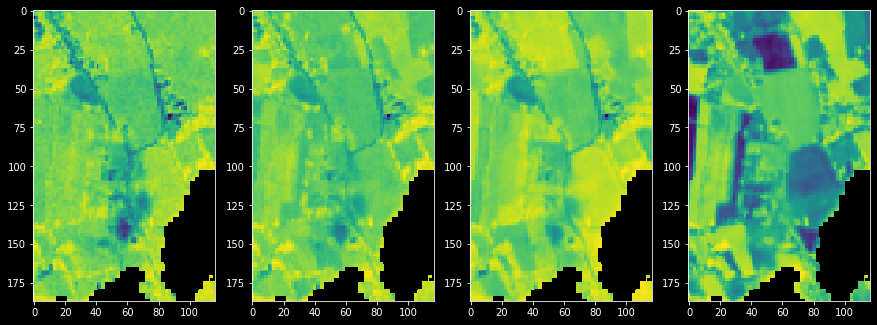

In [39]:

with rasterio.open("hackathon-udf-example-test01.tiff") as dataset:
    fig, axes = plt.subplots(ncols=len(dataset.indexes), figsize=(15,15))
    for i, ax in zip(dataset.indexes, axes):
        data = dataset.read(i, masked=True)
        ax.imshow(data)
        #print(np.max(data))
    